In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


from skimage.morphology import remove_small_objects
def remove_noise(cube):
    thresh_cube = cube>0
    for i in range(cube.shape[0]):
        cube[i] = remove_small_objects(thresh_cube[i], min_size=2) * cube[i]
    return cube

%load_ext autoreload
%autoreload 2

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231215SunnyTest/'

files = os.listdir(dir)

bitdepth = 16
orientation = 'straight'

images = torch.stack([torch.tensor((plt.imread(dir + file) / 2**bitdepth).astype(np.float32)) for file in files if str(bitdepth) in file and orientation in file and 'tiff' in file])

image = torch.mean(images, dim=(0))

image = image[700:1200,950:1450]

image = image / torch.max(image)

bitrate = 1 / images.unique()[1] 

In [51]:
images.std(axis=(0)).mean(), images.mean()

(tensor(9.9702e-05), tensor(0.0009))

In [46]:
image.max(), image.min()

(tensor(1.), tensor(0.0003))

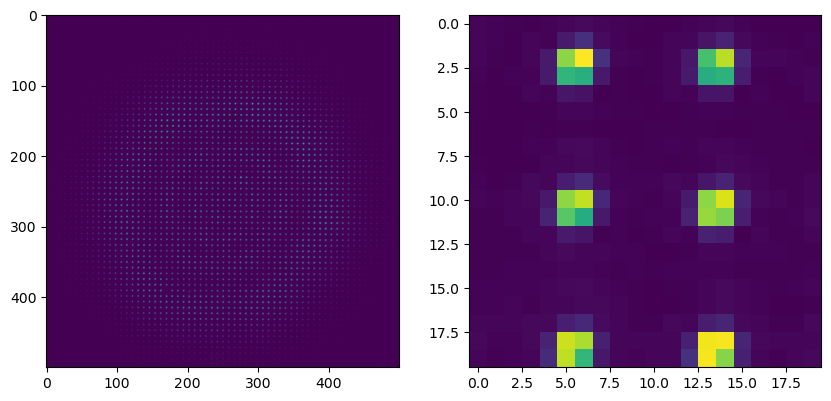

In [54]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(image[180:200,230:250])

In [47]:
torch.save(image, dir + 'straight_image_16.pt', )

In [2]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231016_Monochromator/'

wavelengths_spectra = np.load(dir + 'grating_pinhole_800nm_wavelengths.npy')

# pinhole = []
# pinhole_spectras = []
# mask = []
# mask_spectras = []
pinhole_grating = []
pinhole_grating_spectras = []
lines_grating = []
lines_grating_spectras = []
mask_grating = []
mask_grating_spectras = []

wavelengths = np.arange(752,852,4)

for wl in wavelengths:
    # pinhole.append(np.load(dir + 'pinhole_' + str(wl) + 'nm_image_hdr.npy'))
    # pinhole_spectras.append(np.load(dir + 'pinhole_' + str(wl) + 'nm_spectrum.npy'))
    # mask.append(np.load(dir + 'mask_' + str(wl) + 'nm_image_hdr.npy'))
    # mask_spectras.append(np.load(dir + 'mask_' + str(wl) + 'nm_spectrum.npy'))
    pinhole_grating.append(np.load(dir + 'grating_pinhole_' + str(wl) + 'nm_image_hdr.npy'))
    pinhole_grating_spectras.append(np.load(dir + 'grating_pinhole_' + str(wl) + 'nm_spectrum.npy'))
    lines_grating.append(np.load(dir + 'grating_lines_' + str(wl) + 'nm_image_hdr.npy'))
    lines_grating_spectras.append(np.load(dir + 'grating_lines_' + str(wl) + 'nm_spectrum.npy'))
    mask_grating.append(np.load(dir + 'grating_mask_' + str(wl) + 'nm_image_hdr.npy'))
    mask_grating_spectras.append(np.load(dir + 'grating_mask_' + str(wl) + 'nm_spectrum.npy'))


# pinhole = np.stack(pinhole, axis=0)
# pinhole_spectras = np.stack(pinhole_spectras, axis=0)
pinhole_grating = np.stack(pinhole_grating, axis=0)
pinhole_grating_spectras = np.stack(pinhole_grating_spectras, axis=0)
# mask = np.stack(mask, axis=0)
# mask_spectras = np.stack(mask_spectras, axis=0)
lines_grating = np.stack(lines_grating, axis=0)
lines_grating_spectras = np.stack(lines_grating_spectras, axis=0)
mask_grating = np.stack(mask_grating, axis=0)
mask_grating_spectras = np.stack(mask_grating_spectras, axis=0)

# pinhole = pinhole[:, 630:1430]
# mask = mask[:, 630:1430]
pinhole_grating = pinhole_grating[:, 630:1280]
lines_grating = lines_grating[:, 630:1280]
mask_grating = mask_grating[:, 630:1280]

# pinhole[pinhole<0.005*np.max(pinhole)] = 0
# pinhole_grating[pinhole_grating<0.0005*np.max(pinhole_grating)] = 0
# lines_grating[lines_grating<0.0005*np.max(lines_grating)] = 0
# # mask[mask<0.005*np.max(mask)] = 0
# mask_grating[mask_grating<0.0005*np.max(mask_grating)] = 0

mask_grating[np.isnan(mask_grating)] = np.nan_to_num(mask_grating).max()
lines_grating[np.isnan(lines_grating)] = np.nan_to_num(lines_grating).max()
pinhole_grating[np.isnan(pinhole_grating)] = np.nan_to_num(pinhole_grating).max()


# pinhole_grating = remove_noise(pinhole_grating)

# # # pinhole = pinhole/300
# # mask = mask/300
# pinhole_grating = pinhole_grating/7500
# mask_grating = mask_grating/2500


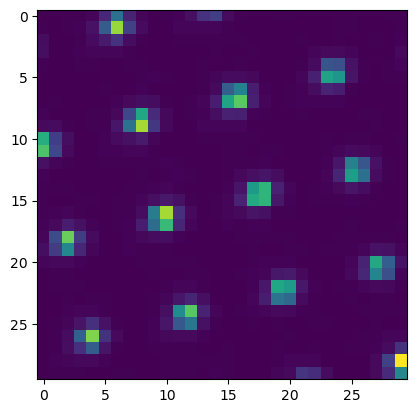

In [3]:
plt.imshow(mask_grating[11,270:300,1220:1250])

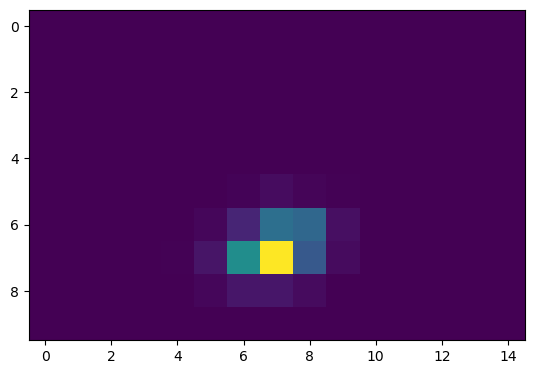

In [4]:
plt.imshow(pinhole_grating[9,450:460,1210:1225])

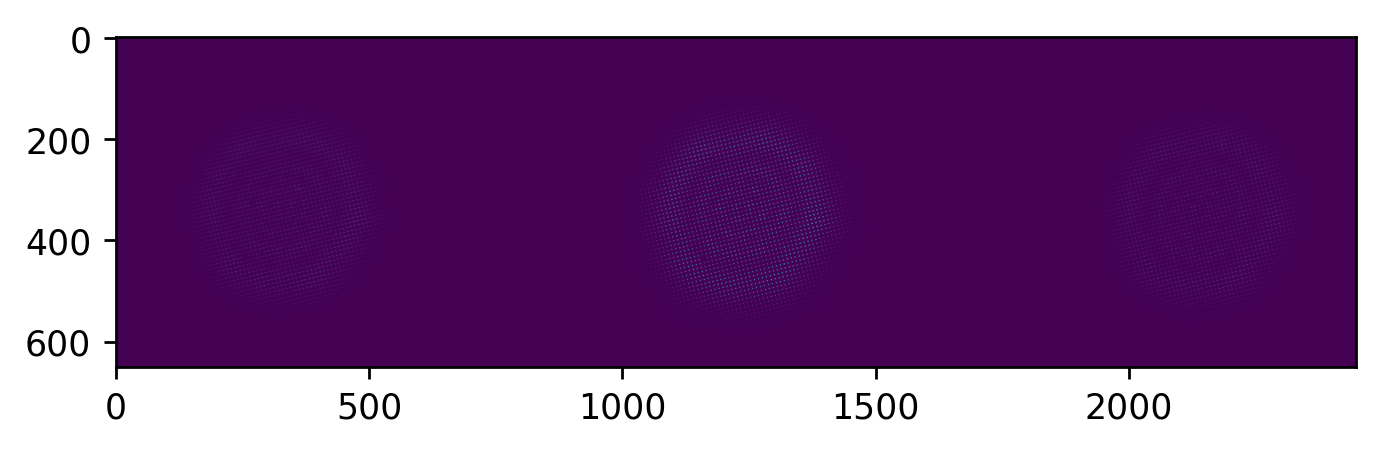

In [5]:
plt.figure(dpi=250)
plt.imshow(mask_grating[7])

In [6]:
# fig,ax = plt.subplots(1,3,dpi=250)
# for i in range(3):
#     ax[i].imshow(pinhole[i,250:300,1200:1250],vmax=5000); ax[i].set_title('20231006_wl'+str(i) )

Text(0.5, 1.0, 'Mask')

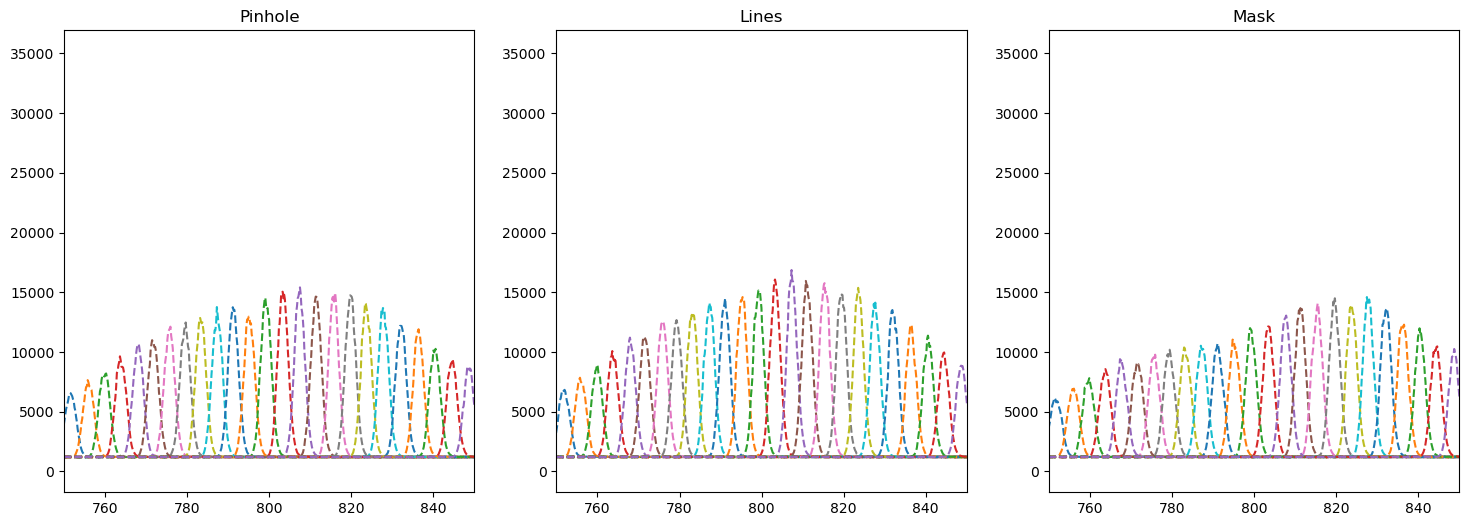

In [7]:
fig,ax = plt.subplots(1,3, figsize=(18,6))
# ax[0].plot(wavelengths_spectra, pinhole_spectras.T); ax[1].set_xlim([750,850]); ax[0].set_title('Pinhole')
# ax[1].plot(wavelengths_spectra, mask_spectras.T); ax[0].set_xlim([750,850]); ax[1].set_title('Mask')
ax[0].plot(wavelengths_spectra, pinhole_grating_spectras.T,'--'); ax[1].set_xlim([750,850]); ax[0].set_title('Pinhole')
ax[1].plot(wavelengths_spectra, lines_grating_spectras.T,'--'); ax[2].set_xlim([750,850]); ax[1].set_title('Lines')
ax[2].plot(wavelengths_spectra, mask_grating_spectras.T,'--'); ax[0].set_xlim([750,850]); ax[2].set_title('Mask')


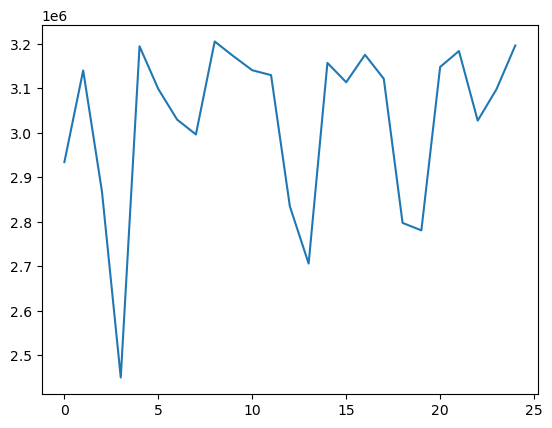

In [8]:
plt.plot(np.sum(pinhole_grating,axis=(1,2)))

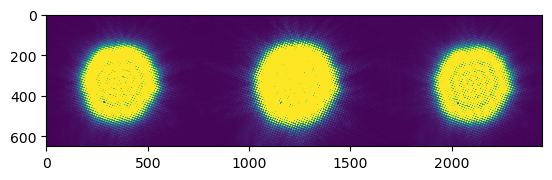

In [9]:
plt.imshow(mask_grating[0],vmax=100)

In [28]:
grating_cube = torch.tensor(pinhole_grating).unsqueeze(0)

max_loc = torch.where(grating_cube == torch.max(grating_cube))
temp = torch.zeros_like(grating_cube)
pad = 20
temp[:,:,max_loc[2]-pad:max_loc[2]+pad,max_loc[3]-pad:max_loc[3]+pad] = grating_cube[:,:,max_loc[2]-pad:max_loc[2]+pad,max_loc[3]-pad:max_loc[3]+pad]
nograting_cube = temp

for i in range(len(wavelengths)):
    nograting_cube[:,i] = nograting_cube[:,i] / torch.sum(nograting_cube[:,i])  * np.sum(pinhole_grating,axis=(1,2))[i] #replace the spectra with that of the nograting cube


grating_cube = grating_cube / torch.sum(grating_cube)
nograting_cube = nograting_cube / torch.sum(nograting_cube)

####### Line

lines_grating_cube = torch.tensor(lines_grating).unsqueeze(0)

max_loc = torch.where(lines_grating_cube == torch.max(lines_grating_cube))
temp = torch.zeros_like(lines_grating_cube)
temp[:,:,:,750:1600] = lines_grating_cube[:,:,:,750:1600]
lines_nograting_cube = temp

for i in range(len(wavelengths)):
    lines_nograting_cube[:,i] = lines_nograting_cube[:,i] / torch.sum(lines_nograting_cube[:,i])  * np.sum(lines_grating,axis=(1,2))[i] #replace the spectra with that of the nograting cube

lines_grating_cube = lines_grating_cube / torch.sum(lines_grating_cube)
lines_nograting_cube = lines_nograting_cube / torch.sum(lines_nograting_cube)

######## Mask

mask_grating_cube = torch.tensor(mask_grating).unsqueeze(0)

max_loc = torch.where(mask_grating_cube == torch.max(mask_grating_cube))
temp = torch.zeros_like(mask_grating_cube)
temp[:,:,:,750:1600] = mask_grating_cube[:,:,:,750:1600]
mask_nograting_cube = temp

for i in range(len(wavelengths)):
    mask_nograting_cube[:,i] = mask_nograting_cube[:,i] / torch.sum(mask_nograting_cube[:,i])  * np.sum(mask_grating,axis=(1,2))[i] #replace the spectra with that of the nograting cube

mask_grating_cube = mask_grating_cube / torch.sum(mask_grating_cube)
mask_nograting_cube = mask_nograting_cube / torch.sum(mask_nograting_cube)

In [29]:
torch.save(grating_cube, dir + 'pinhole_cube_grating.pt', )
torch.save(nograting_cube, dir + 'pinhole_cube_nograting.pt', )

torch.save(lines_grating_cube, dir + 'lines_cube_grating.pt', )
torch.save(lines_nograting_cube, dir + 'lines_cube_nograting.pt', )

torch.save(mask_grating_cube, dir + 'mask_cube_grating.pt', )
torch.save(mask_nograting_cube, dir + 'mask_cube_nograting.pt', )

## Test the field curvature

In [149]:
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass

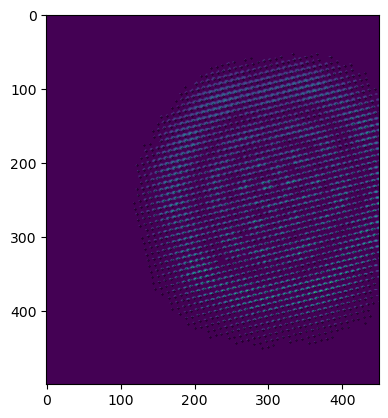

In [192]:
spot0 = mask_grating[0,100:600,50:500]

spot1 = mask_grating[0,100:600,50:500]

spot1[spot1 < 0.1*np.max(spot1)] = 0

peaks = peak_local_max(spot1,min_distance=5)

plt.imshow(spot1)
plt.scatter(peaks[:,1],peaks[:,0],s=0.1,c='k')

In [193]:
pad = 3
coms = []
coms_minus1 = []


spotpos = np.zeros_like(peaks, dtype=float)


for i,peak in enumerate(peaks):
    region=spot1[peak[0]-pad:peak[0]+pad,peak[1]-pad:peak[1]+pad] 

    spotpos[i] = peak + np.array(center_of_mass(region))


In [194]:
from scipy.spatial.distance import cdist

In [195]:
distances = cdist(spotpos,spotpos)

distances[distances == 0 ] = 10000

In [196]:
keeplist = []

relative_distances = np.zeros((len(spotpos),4)) #find the distance to above, left, right , below

for i in range(len(distances)):
    if np.sum(distances[i]<10) == 4:
        keeplist.append(i)
        
        bla = np.where(distances[i]<10)

        neighbourcoords = spotpos[bla]

        neighbourdists = neighbourcoords - spotpos[i]

        relative_distances[i,0] = np.linalg.norm(neighbourdists[neighbourdists.argmax(0)[0]])
        relative_distances[i,1] = np.linalg.norm(neighbourdists[neighbourdists.argmax(0)[1]])
        relative_distances[i,2] = np.linalg.norm(neighbourdists[neighbourdists.argmin(0)[1]])
        relative_distances[i,-1] = np.linalg.norm(neighbourdists[neighbourdists.argmin(0)[0]])

        spotpos[i]
    else: 
        continue

In [197]:
relative_distances = relative_distances[keeplist]
spotpos = spotpos[keeplist]

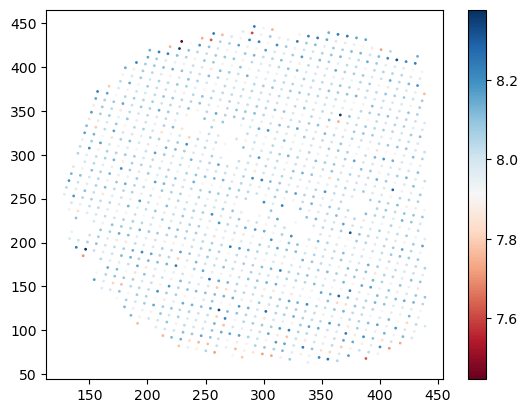

In [200]:
plt.scatter(spotpos[:,1],spotpos[:,0],s=1,c=relative_distances[:,0],cmap='RdBu')
plt.colorbar()

In [33]:
spotpos

array([[366.00976894, 333.62369877],
       [362.08693995, 315.88360287],
       [267.06754836, 400.08878064],
       ...,
       [168.        , 467.        ],
       [357.        ,  66.        ],
       [ 97.        , 118.        ]])

## If we need to rotate them

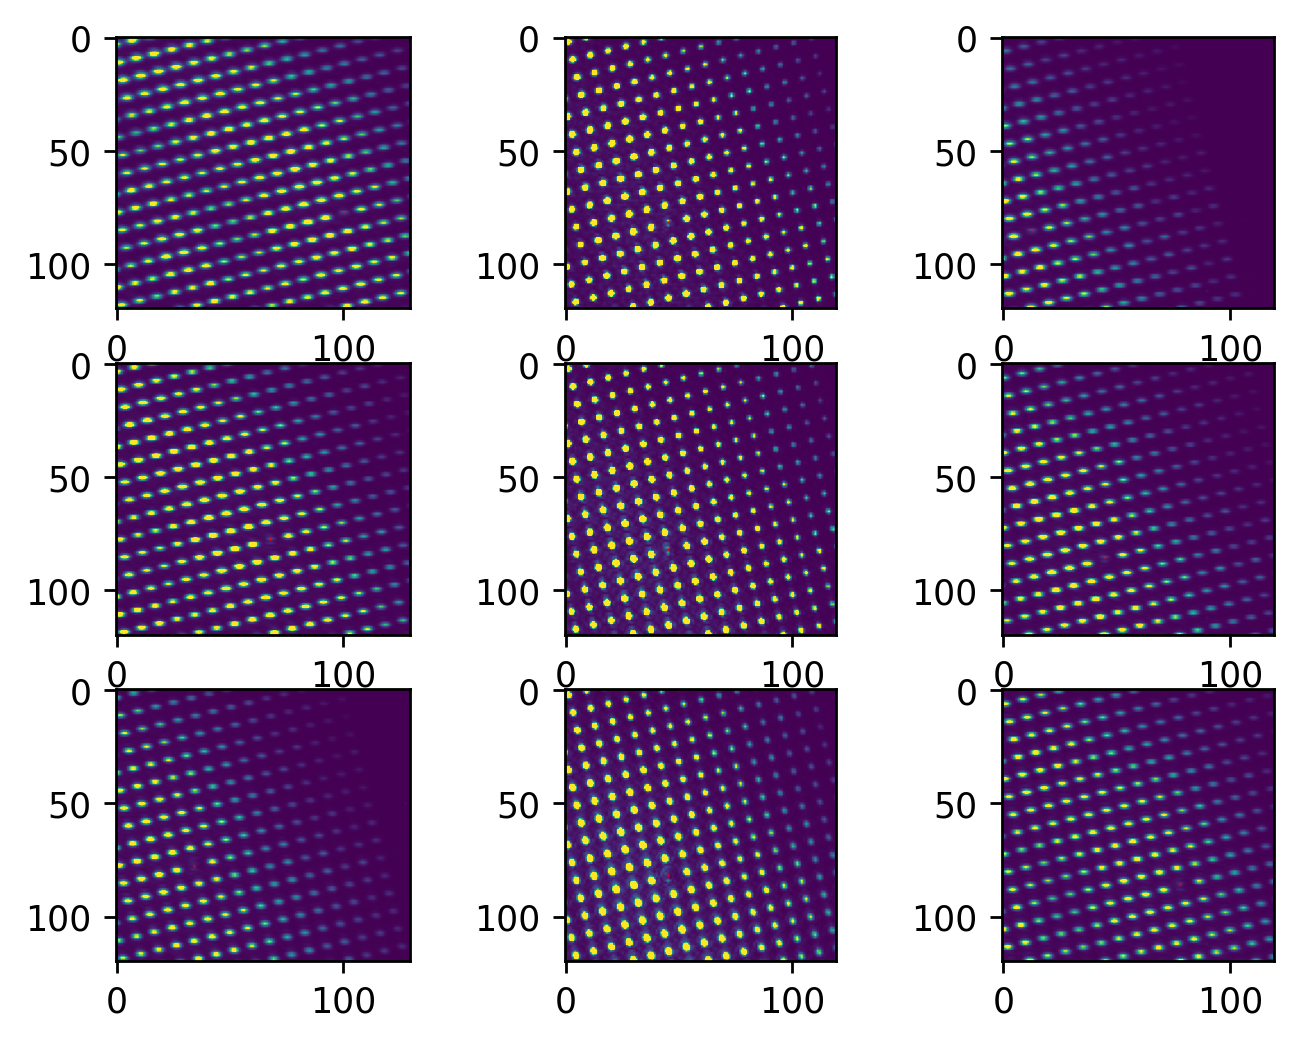

In [5]:
fig,ax = plt.subplots(3,3,dpi=250)
ax[0,0].imshow(mask_grating[5,200:320,370:500],vmax=1000);
minus1 = [100.5,77]
ax[0,0].plot(minus1[0],minus1[1],'r*', ms=0.1)

ax[0,1].imshow(mask_grating[5,200:320,1320:1440],vmax=1000);
funda = [45,81.5]
ax[0,1].plot(funda[0],funda[1],'r*', ms=0.1)

ax[0,2].imshow(mask_grating[5,200:320,2250:2370],vmax=1000);
plus1 = [12.5,85]
ax[0,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl5_delta_p1 = plus1[0] + 200 - (funda[0]+200),  plus1[1] + 2250 - (funda[1]+1320), 
wl5_delta_m1 = minus1[0] + 200 - (funda[0]+200),  minus1[1] + 370 - (funda[1]+1320)

##################

ax[1,0].imshow(mask_grating[12,200:320,370:500],vmax=1000);
minus1 = [67.7,77.5]
ax[1,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[1,1].imshow(mask_grating[12,200:320,1320:1440],vmax=1000);
funda = [45,81.5]
ax[1,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[1,2].imshow(mask_grating[12,200:320,2250:2370],vmax=1000);
plus1 = [45,85.3]
ax[1,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl12_delta_p1 = (plus1[0] + 200) - (funda[0]+200),  (plus1[1] + 2250) - (funda[1]+1320),
wl12_delta_m1 = (minus1[0] + 200) - (funda[0]+200),  (minus1[1] + 370) - (funda[1]+1320)

######################

ax[2,0].imshow(mask_grating[19,200:320,370:500],vmax=1000);
minus1 = [34,77.5]
ax[2,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[2,1].imshow(mask_grating[19,200:320,1320:1440],vmax=1000);
funda = [45,81.5]
ax[2,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[2,2].imshow(mask_grating[19,200:320,2250:2370],vmax=1000);
plus1 = [78,85.8]
ax[2,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl19_delta_p1 = (plus1[0] + 200) - (funda[0]+200),  (plus1[1] + 2250) - (funda[1]+1320),
wl19_delta_m1 = (minus1[0] + 200) - (funda[0]+200),  (minus1[1] + 370) - (funda[1]+1320)


In [6]:
measured_shifts = np.array([wl5_delta_p1, wl12_delta_p1 , wl19_delta_p1])
correct_shifts = np.stack([np.zeros(3),np.linalg.norm(np.abs(measured_shifts),axis=1)],axis=1)

correct_shifts[:,1] *= measured_shifts[:,1]/np.abs(measured_shifts[:,1])

corrections = correct_shifts - measured_shifts


from scipy.interpolate import interp1d

newcorrections = np.zeros((wavelengths.shape[0],2))

f = interp1d(x = [wavelengths[5], wavelengths[12], wavelengths[19]], y = corrections[:,0], kind='linear', fill_value='extrapolate')
newcorrections[:,0] = f(wavelengths)

f = interp1d(x = [wavelengths[5], wavelengths[12], wavelengths[19]], y = corrections[:,1], kind='linear', fill_value='extrapolate')
newcorrections[:,1] = f(wavelengths)


In [7]:
import scipy.ndimage
def shiftrotation(cube, correction_shifts, ranges = [800,1800]):

     #corrections are the x and y correction for wavelengths

     newcube = cube.copy()

     newcube[...,:ranges[0]] = np.stack([scipy.ndimage.shift(cube[i,...,:ranges[0]], shift = (-correction_shifts[i,0],-correction_shifts[i,1]), order = 1) for i in range(len(cube))],axis=0)
     newcube[...,ranges[1]:] = np.stack([scipy.ndimage.shift(cube[i,...,ranges[1]:], shift = (correction_shifts[i,0],correction_shifts[i,1]), order = 1) for i in range(len(cube))],axis=0)

     return newcube


In [8]:
mask_grating_rot = shiftrotation(cube = mask_grating, correction_shifts = newcorrections, ranges = [800,1800])

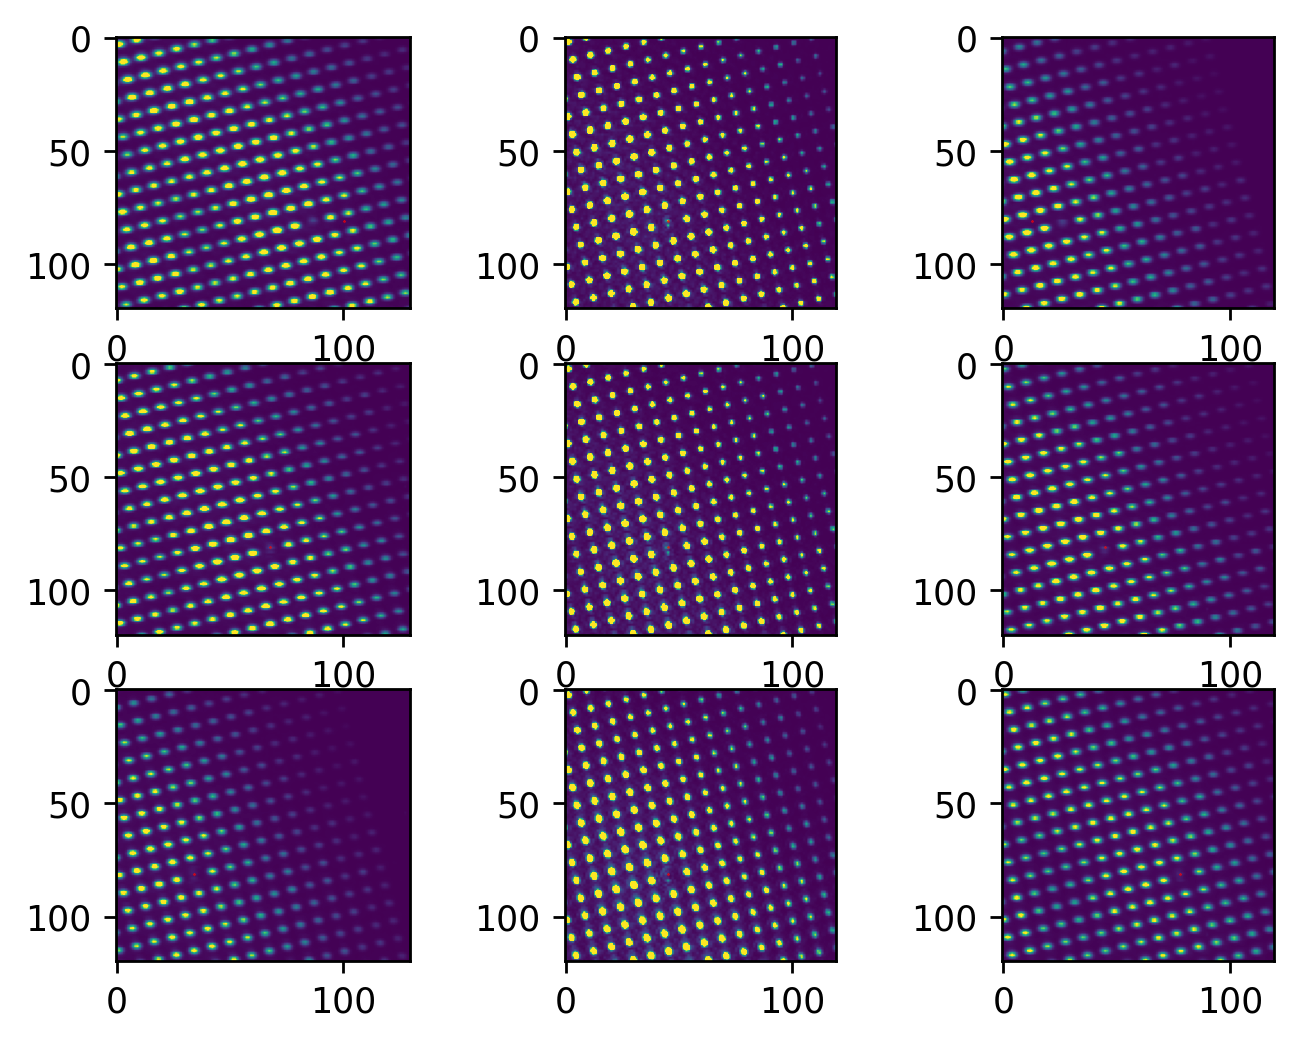

In [9]:
fig,ax = plt.subplots(3,3,dpi=250)
ax[0,0].imshow(mask_grating_rot[8,200:320,370:500],vmax=1000);
minus1 = [100.5,81]
ax[0,0].plot(minus1[0],minus1[1],'r*', ms=0.1)

ax[0,1].imshow(mask_grating_rot[8,200:320,1320:1440],vmax=1000);
funda = [45,81]
ax[0,1].plot(funda[0],funda[1],'r*', ms=0.1)

ax[0,2].imshow(mask_grating_rot[8,200:320,2250:2370],vmax=1000);
plus1 = [12.5,81]
ax[0,2].plot(plus1[0],plus1[1],'r*', ms=0.1)


##################

ax[1,0].imshow(mask_grating_rot[12,200:320,370:500],vmax=1000);
minus1 = [67.7,81]
ax[1,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[1,1].imshow(mask_grating_rot[12,200:320,1320:1440],vmax=1000);
funda = [45,81]
ax[1,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[1,2].imshow(mask_grating_rot[12,200:320,2250:2370],vmax=1000);
plus1 = [45,81]
ax[1,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

######################

ax[2,0].imshow(mask_grating_rot[19,200:320,370:500],vmax=1000);
minus1 = [34,81]
ax[2,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[2,1].imshow(mask_grating_rot[19,200:320,1320:1440],vmax=1000);
funda = [45,81]
ax[2,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[2,2].imshow(mask_grating_rot[19,200:320,2250:2370],vmax=1000);
plus1 = [78,81]
ax[2,2].plot(plus1[0],plus1[1],'r*', ms=0.1)


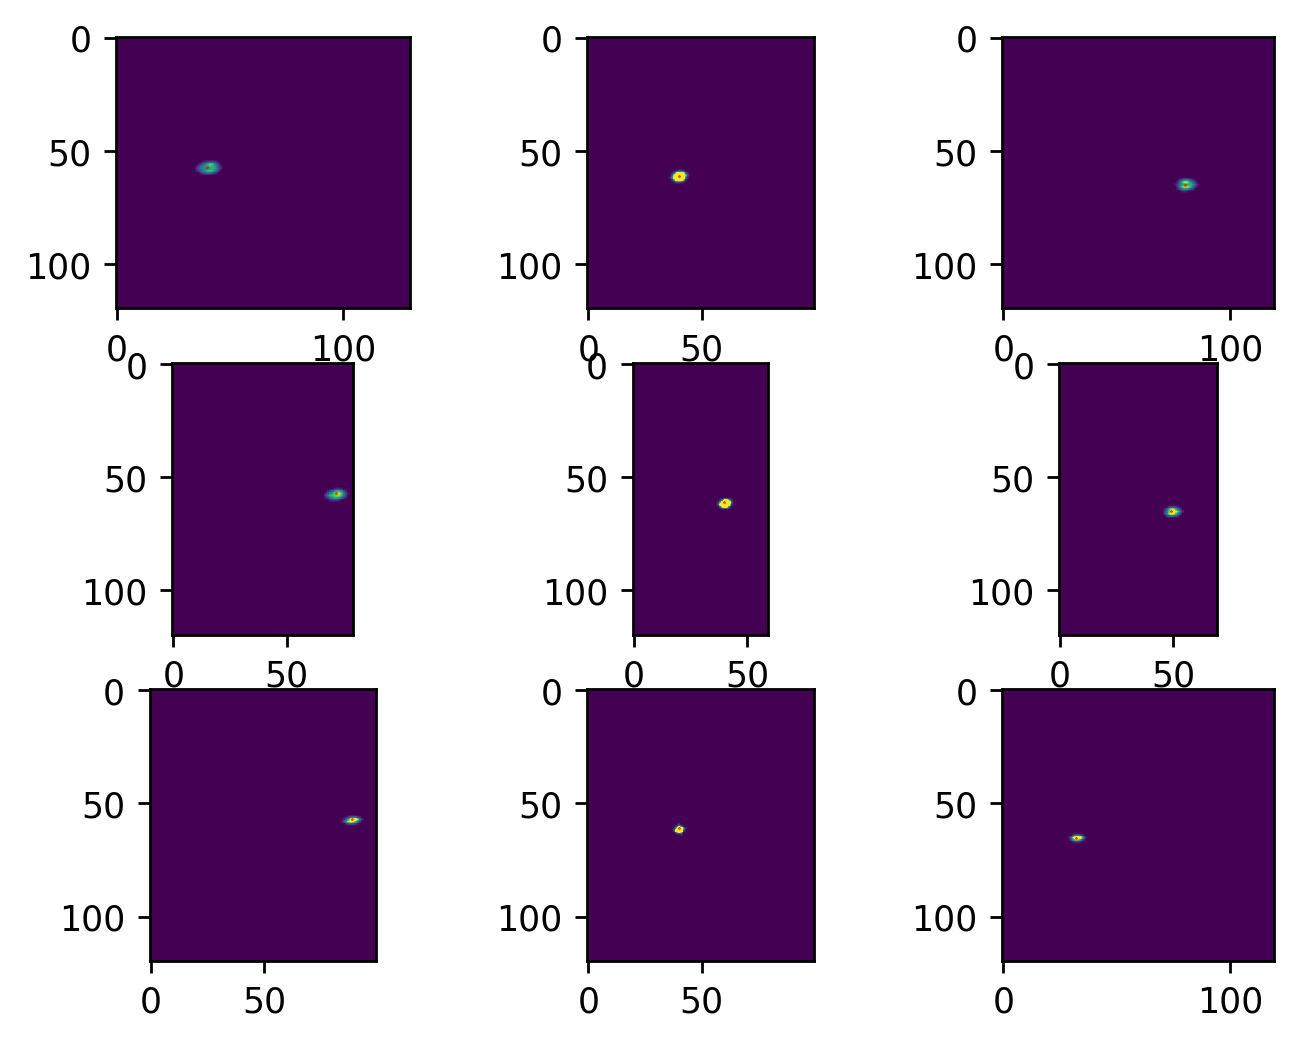

In [10]:
fig,ax = plt.subplots(3,3,dpi=250)
ax[0,0].imshow(pinhole_grating[8,400:520,270:400],vmax=1000);
minus1 = [40,57]
ax[0,0].plot(minus1[0],minus1[1],'r*', ms=0.1)

ax[0,1].imshow(pinhole_grating[8,400:520,1180:1280],vmax=1000);
funda = [40,61]
ax[0,1].plot(funda[0],funda[1],'r*', ms=0.1)

ax[0,2].imshow(pinhole_grating[8,400:520,2050:2170],vmax=1000);
plus1 = [80,65]
ax[0,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl5_delta_p1 = plus1[0] + 400 - (funda[0]+400),  plus1[1] + 2050 - (funda[1]+1180), 
wl5_delta_m1 = minus1[0] + 400 - (funda[0]+400),  minus1[1] + 270 - (funda[1]+1180)

##################

ax[1,0].imshow(pinhole_grating[12,400:520,220:300],vmax=1000);
minus1 = [72,57]
ax[1,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[1,1].imshow(pinhole_grating[12,400:520,1180:1240],vmax=1000);
funda = [40,61]
ax[1,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[1,2].imshow(pinhole_grating[12,400:520,2100:2170],vmax=1000);
plus1 = [49,65]
ax[1,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl12_delta_p1 = (plus1[0] + 400) - (funda[0]+400),  (plus1[1] + 2100) - (funda[1]+1180),
wl12_delta_m1 = (minus1[0] + 400) - (funda[0]+400),  (minus1[1] + 220) - (funda[1]+1180)

######################

ax[2,0].imshow(pinhole_grating[19,400:520,170:270],vmax=1000);
minus1 = [89,57]
ax[2,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[2,1].imshow(pinhole_grating[19,400:520,1180:1280],vmax=1000);
funda = [40,61]
ax[2,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[2,2].imshow(pinhole_grating[19,400:520,2150:2270],vmax=1000);
plus1 = [32,65.5]
ax[2,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

minus1 = np.flip(minus1)
funda = np.flip(funda)
plus1 = np.flip(plus1)

wl19_delta_p1 = (plus1[0] + 400) - (funda[0]+400),  (plus1[1] + 2150) - (funda[1]+1180),
wl19_delta_m1 = (minus1[0] + 400) - (funda[0]+400),  (minus1[1] + 170) - (funda[1]+1180)

In [11]:
measured_shifts = np.array([wl5_delta_p1, wl12_delta_p1 , wl19_delta_p1])
correct_shifts = np.stack([np.zeros(3),np.linalg.norm(np.abs(measured_shifts),axis=1)],axis=1)

correct_shifts[:,1] *= measured_shifts[:,1]/np.abs(measured_shifts[:,1])

corrections = correct_shifts - measured_shifts


from scipy.interpolate import interp1d

newcorrections = np.zeros((wavelengths.shape[0],2))

f = interp1d(x = [wavelengths[5], wavelengths[12], wavelengths[19]], y = corrections[:,0], kind='linear', fill_value='extrapolate')
newcorrections[:,0] = f(wavelengths)

f = interp1d(x = [wavelengths[5], wavelengths[12], wavelengths[19]], y = corrections[:,1], kind='linear', fill_value='extrapolate')
newcorrections[:,1] = f(wavelengths)


In [12]:
pinhole_grating_rot = shiftrotation(cube = pinhole_grating, correction_shifts = newcorrections, ranges = [800,1800])

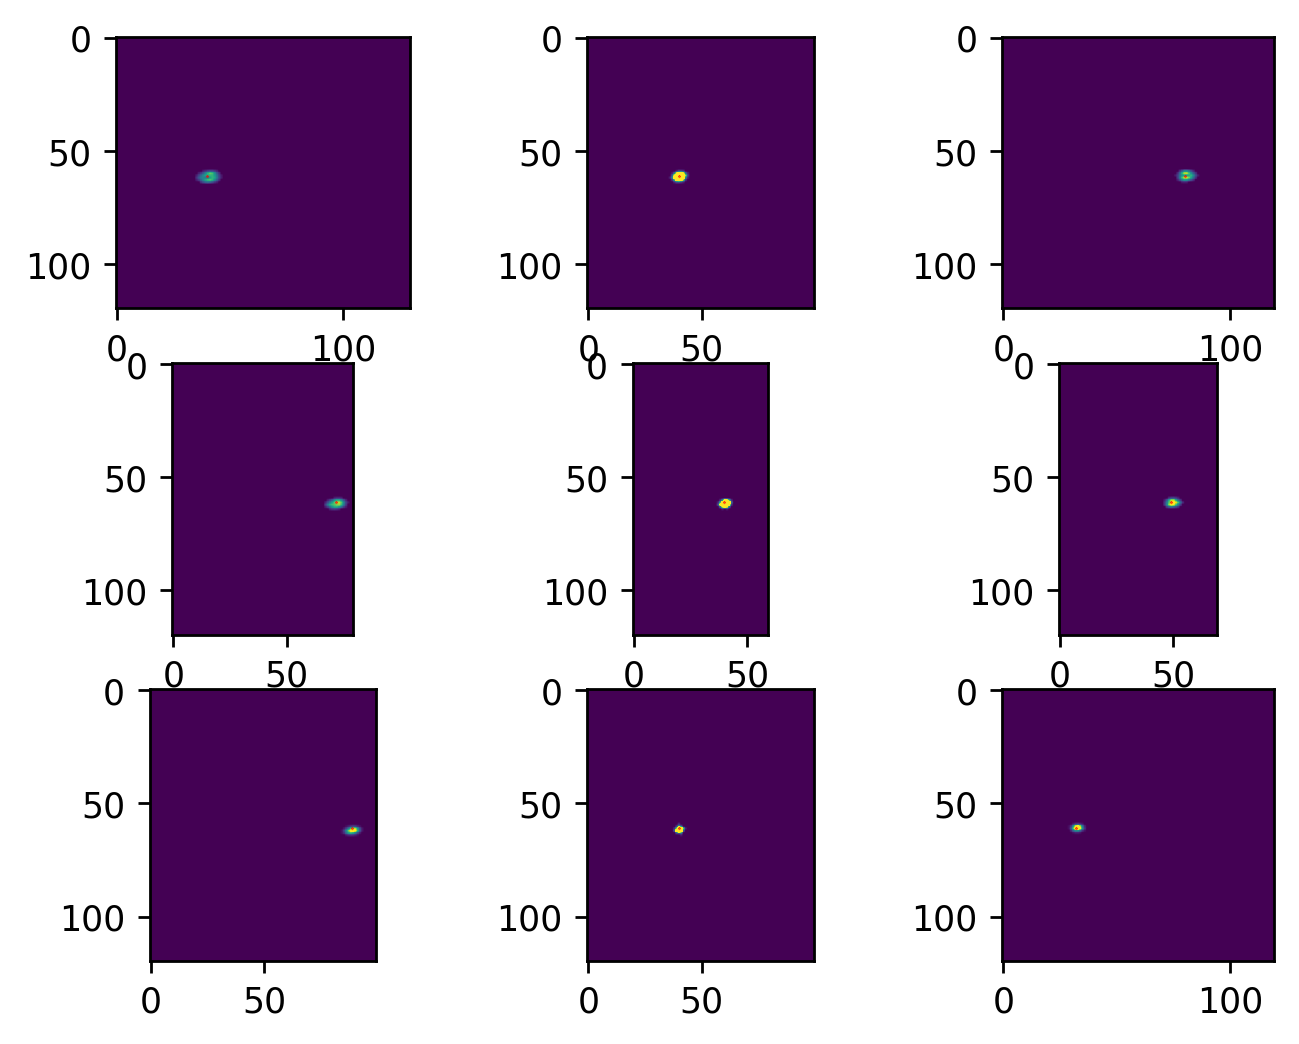

In [13]:
fig,ax = plt.subplots(3,3,dpi=250)
ax[0,0].imshow(pinhole_grating_rot[8,400:520,270:400],vmax=1000);
minus1 = [40,61]
ax[0,0].plot(minus1[0],minus1[1],'r*', ms=0.1)

ax[0,1].imshow(pinhole_grating_rot[8,400:520,1180:1280],vmax=1000);
funda = [40,61]
ax[0,1].plot(funda[0],funda[1],'r*', ms=0.1)

ax[0,2].imshow(pinhole_grating_rot[8,400:520,2050:2170],vmax=1000);
plus1 = [80,61]
ax[0,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

##################

ax[1,0].imshow(pinhole_grating_rot[12,400:520,220:300],vmax=1000);
minus1 = [72,61]
ax[1,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[1,1].imshow(pinhole_grating_rot[12,400:520,1180:1240],vmax=1000);
funda = [40,61]
ax[1,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[1,2].imshow(pinhole_grating_rot[12,400:520,2100:2170],vmax=1000);
plus1 = [49,61]
ax[1,2].plot(plus1[0],plus1[1],'r*', ms=0.1)

######################

ax[2,0].imshow(pinhole_grating_rot[19,400:520,170:270],vmax=1000);
minus1 = [89,61]
ax[2,0].plot(minus1[0],minus1[1],'r*', ms=0.1)
ax[2,1].imshow(pinhole_grating_rot[19,400:520,1180:1280],vmax=1000);
funda = [40,61]
ax[2,1].plot(funda[0],funda[1],'r*', ms=0.1)
ax[2,2].imshow(pinhole_grating_rot[19,400:520,2150:2270],vmax=1000);
plus1 = [32,61]
ax[2,2].plot(plus1[0],plus1[1],'r*', ms=0.1)


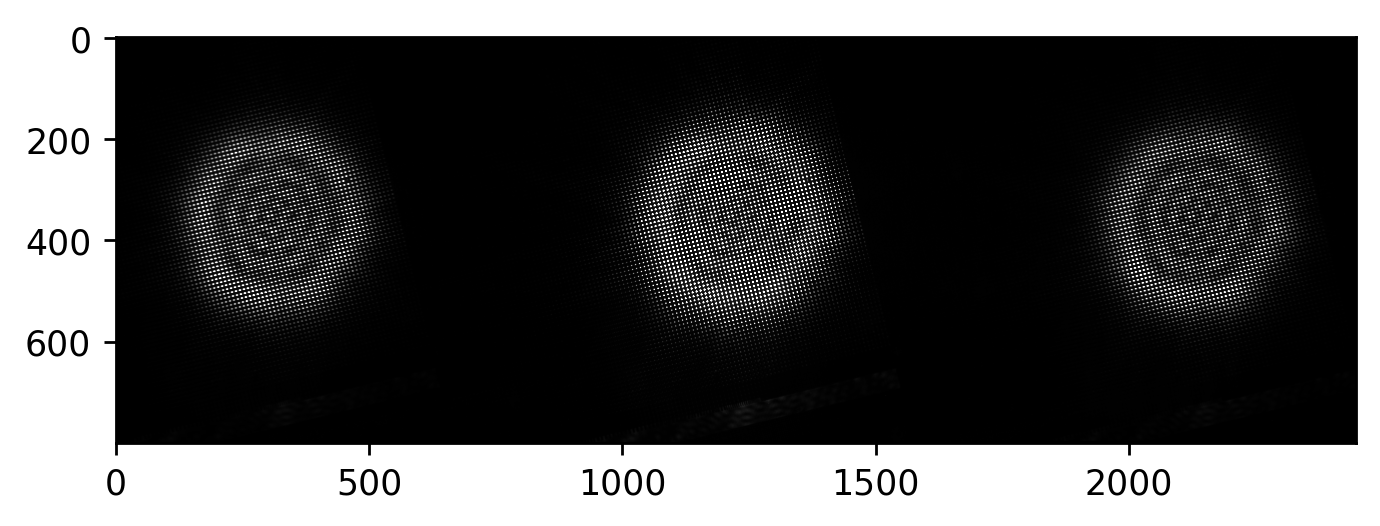

In [14]:
plt.figure(dpi=250)
plt.imshow(mask_grating_rot[8], cmap='gray',vmax=1000)

In [15]:
grating_cube = torch.tensor(pinhole_grating_rot).unsqueeze(0)

nograting_cube = torch.tensor(pinhole).unsqueeze(0)

max_loc = torch.where(nograting_cube == torch.max(nograting_cube))
temp = torch.zeros_like(nograting_cube)
pad = 5
temp[:,:,max_loc[2]-pad:max_loc[2]+pad,max_loc[3]-pad:max_loc[3]+pad] = nograting_cube[:,:,max_loc[2]-pad:max_loc[2]+pad,max_loc[3]-pad:max_loc[3]+pad]
nograting_cube = temp


grating_cube = grating_cube / torch.sum(grating_cube)
nograting_cube = nograting_cube / torch.sum(nograting_cube)

nograting_cube, grating_cube = hlp.center_cubes(nograting_cube, grating_cube,  device='cpu')
nograting_cube = hlp.shift_nograting_to_grating(nograting_cube, grating_cube, y_range=[0,nograting_cube.shape[2]],device='cpu')


torch.save(grating_cube, dir + 'pinhole_cube_grating.pt', )
torch.save(nograting_cube, dir + 'pinhole_cube_nograting.pt', )


mask = np.nan_to_num(mask)
mask_grating = np.nan_to_num(mask_grating_rot)
mask_nograting_cube = torch.tensor(mask).unsqueeze(0)
mask_grating_cube = torch.tensor(mask_grating).unsqueeze(0)

mask_grating_cube = mask_grating_cube / torch.sum(mask_grating_cube)
mask_nograting_cube = mask_nograting_cube / torch.sum(mask_nograting_cube)

shifts = [-0.05,-2.3]

import scipy.ndimage
mask_grating_cube = torch.tensor(scipy.ndimage.shift(mask_grating_cube.cpu(), shift = (0,0,shifts[0],shifts[1]), order = 1))


torch.save(mask_grating_cube, dir + 'mask_cube_grating.pt', )
torch.save(mask_nograting_cube,dir + 'mask_cube_nograting.pt', )




to center grating we move by = (tensor(62), tensor(-4))
to shift nograting to grating we move by = [0.70915676 1.9397061 ]


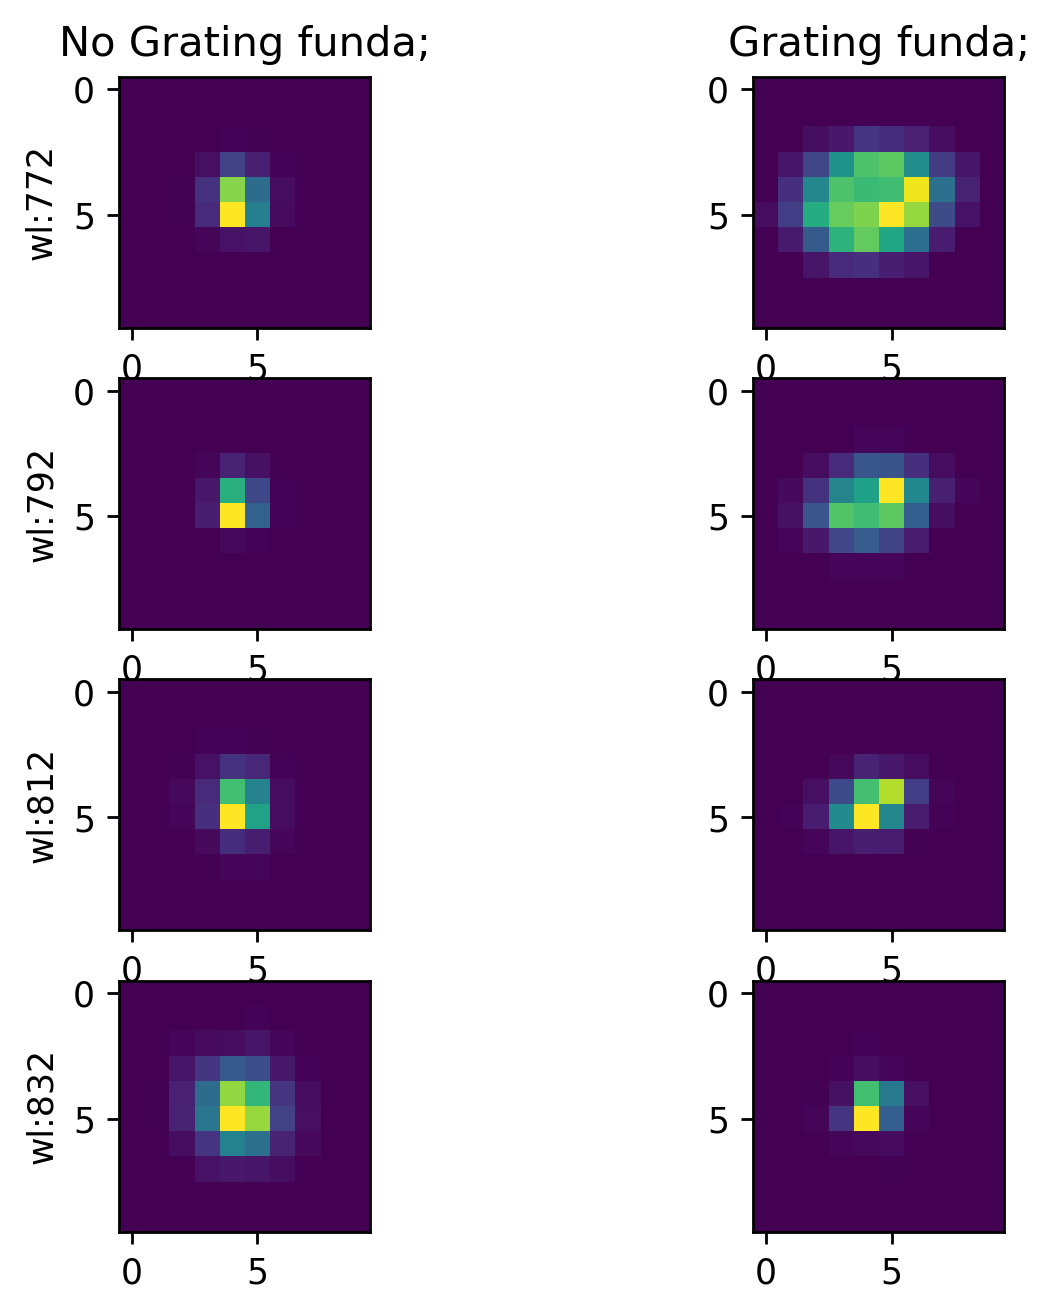

In [41]:
fig,ax = plt.subplots(4,2,figsize=(6,6),dpi=250)

wl = 20

for n,wl in enumerate([5,10,15,20]):
    ax[n,0].imshow(nograting_cube[0,wl,395:405,1220:1230]); ax[0,0].set_title(f'No Grating funda;'); ax[n,0].set_ylabel(f'wl:{wavelengths[wl]}')
    ax[n,1].imshow(grating_cube[0,wl,395:405,1220:1230],);ax[0,1].set_title(f'Grating funda;')


In [193]:
mask_grating_cube.max()

tensor(2.5816e-05, dtype=torch.float64)

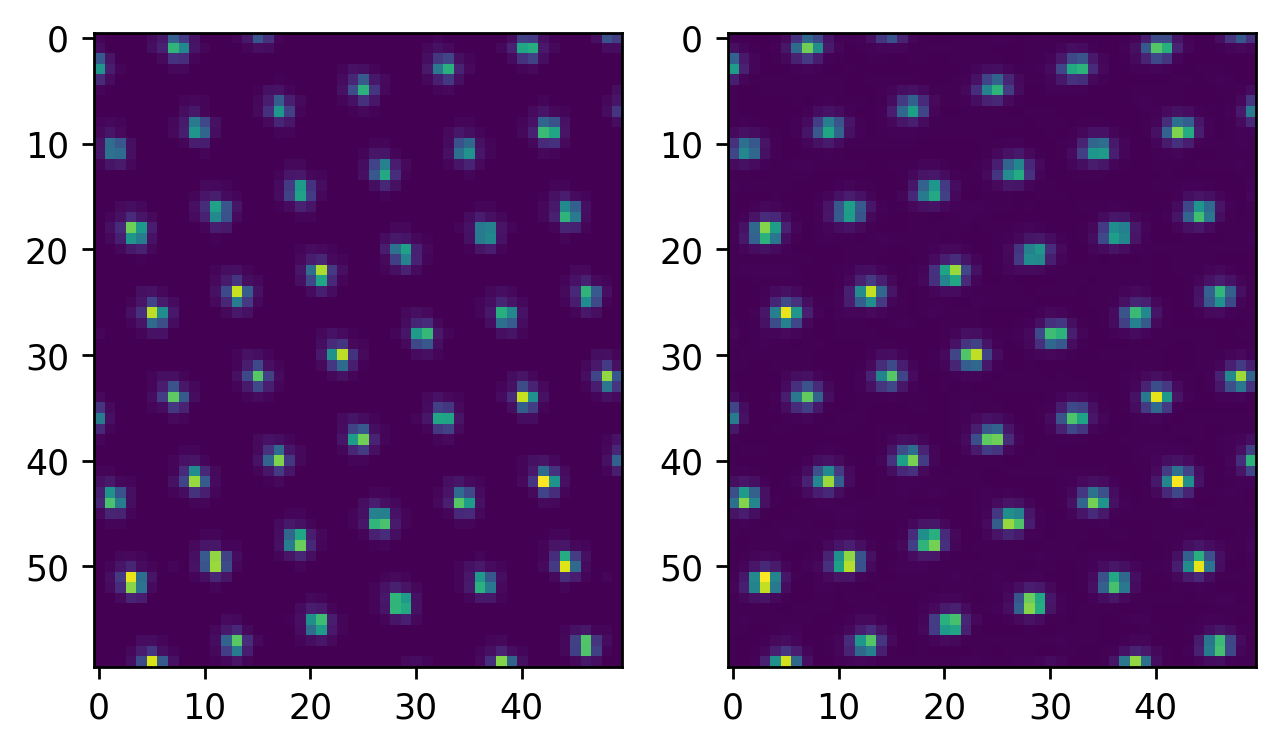

In [194]:
fig,ax = plt.subplots(1,2,figsize=(6,6),dpi=250)

wl = 1

ax[0].imshow(mask_nograting_cube[0,wl,220:280,1200:1250])
ax[1].imshow(mask_grating_cube[0,wl,220:280,1200:1250])

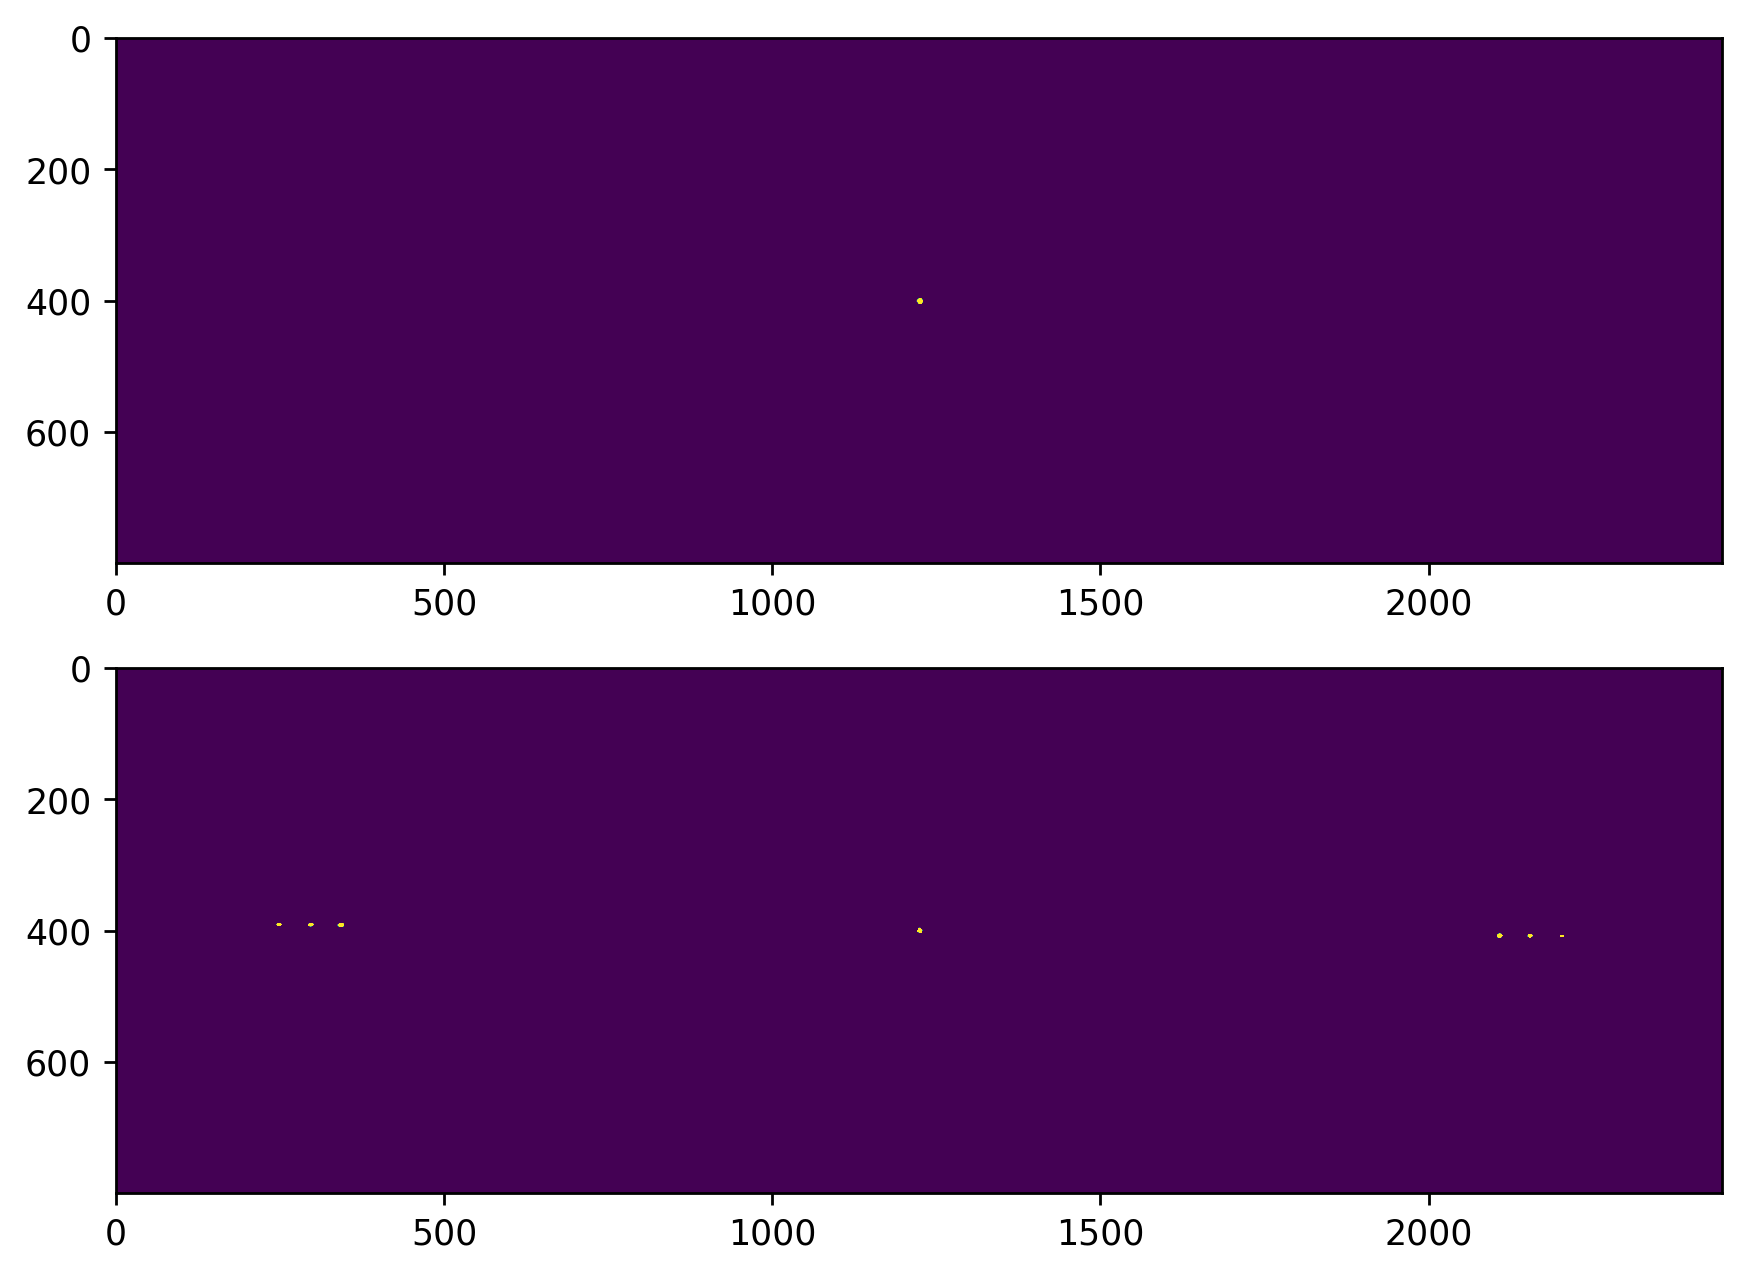

In [195]:
fig,ax = plt.subplots(2,1,figsize=(12,6),dpi=250)

ax[0].imshow(nograting_cube.sum(dim=(0,1)),vmax=0.0001)
ax[1].imshow(grating_cube.sum(dim=(0,1)),vmax=0.0001)

### Use kernel learner to get the kernel

In [196]:
kernel = torch.load('../kernel_mono.pt',map_location='cpu').requires_grad_(False)

In [197]:
# kernel = disperser.undisperse_all_orders(grating_cube, nograting_cube, wiener=False, lamb=0.0000001)

# kernel[kernel<kernel.max()*0.001] = 0

In [198]:
kernel.min(), kernel.max()

(tensor(0.), tensor(0.8273))

In [199]:
pred = disperser.disperse_all_orders(nograting_cube, kernel = kernel)

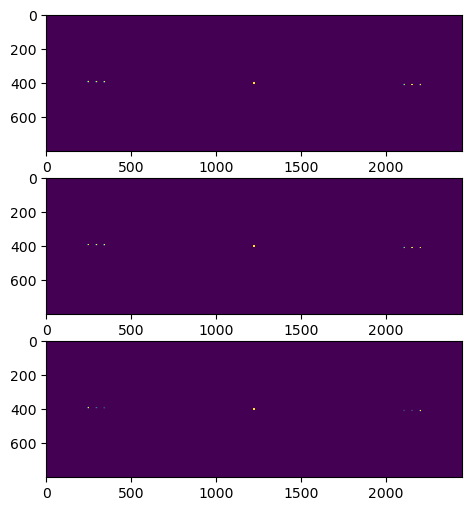

In [200]:
fig,ax = plt.subplots(3,1, figsize=(18,6))
ax[0].imshow(pred.sum(dim=(0,1)).numpy(), vmax=0.001)
ax[1].imshow(grating_cube.sum(dim=(0,1)).numpy(),vmax=0.001)
ax[2].imshow(np.sum(np.abs(grating_cube.numpy() - pred.numpy()),axis=(0,1)), vmax = 0.001)

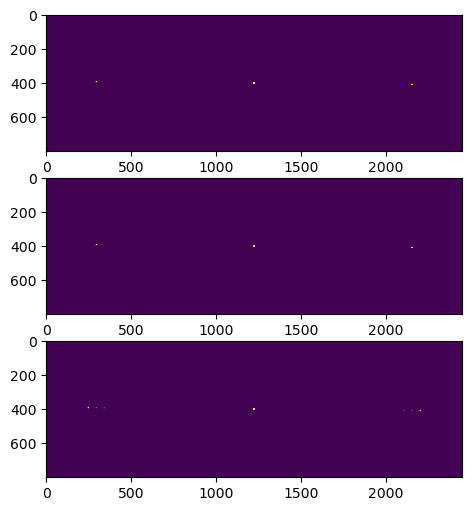

In [201]:
fig,ax = plt.subplots(3,1, figsize=(18,6))
ax[0].imshow(pred[0,1].numpy(), vmax=0.001)
ax[1].imshow(grating_cube[0,1].numpy(),vmax=0.001)
ax[2].imshow(np.sum(np.abs(grating_cube.numpy() - pred.numpy()),axis=(0,1)), vmax = 0.001)

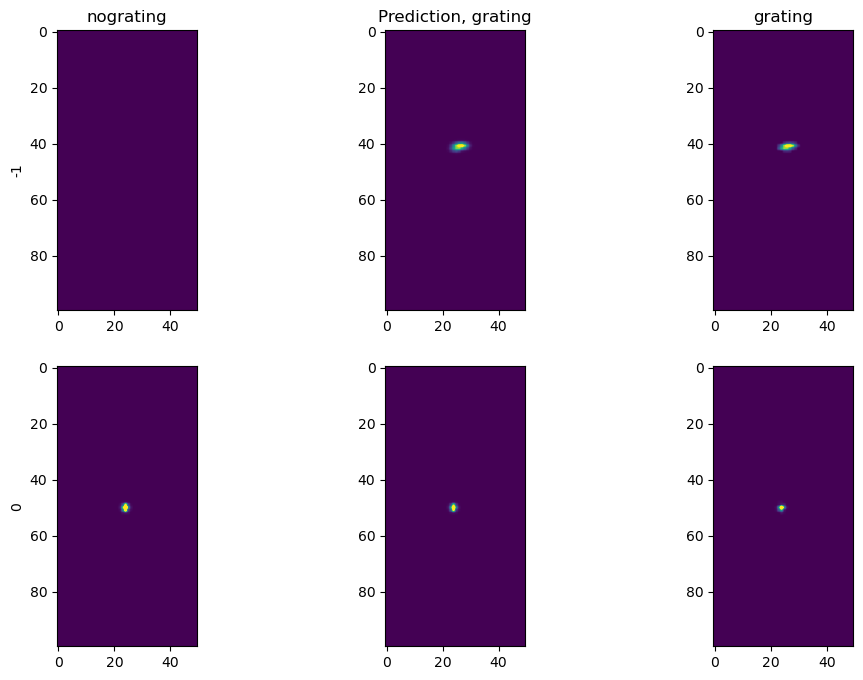

In [203]:
fig,ax = plt.subplots(2,3, figsize=(12,8))
ax[0,0].imshow(nograting_cube[0,1:2,350:450,270:320].sum(0).numpy(), vmax=0.01); ax[0,0].set_ylabel('-1');ax[0,0].set_title('nograting')
ax[0,1].imshow(pred[0,1:2,350:450,270:320].sum(0).numpy(), vmax=0.01); ax[0,1].set_title('Prediction, grating')
ax[0,2].imshow(grating_cube[0,1:2,350:450,270:320].sum(0).numpy(),vmax=0.01); ax[0,2].set_title('grating')
ax[1,0].imshow(nograting_cube[0,1:2,350:450,1200:1250].sum(0).numpy(), vmax=0.05); ax[1,0].set_ylabel('0')
ax[1,1].imshow(pred[0,1:2,350:450,1200:1250].sum(0).numpy(), vmax=0.05)
ax[1,2].imshow(grating_cube[0,1:2,350:450,1200:1250].sum(0).numpy(),vmax=0.05);


In [204]:
pred = disperser.disperse_all_orders(mask_nograting_cube, kernel = kernel)

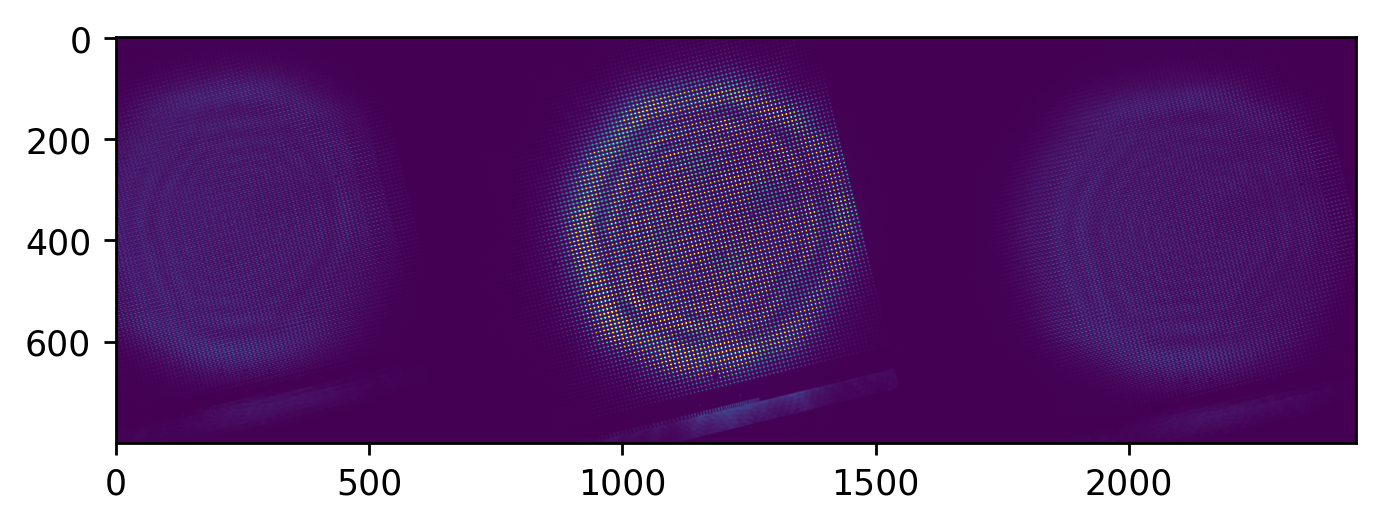

In [205]:
plt.figure(dpi=250)
plt.imshow(mask_grating_cube.sum(dim=(0,1)).numpy(),  vmax = 0.00001)


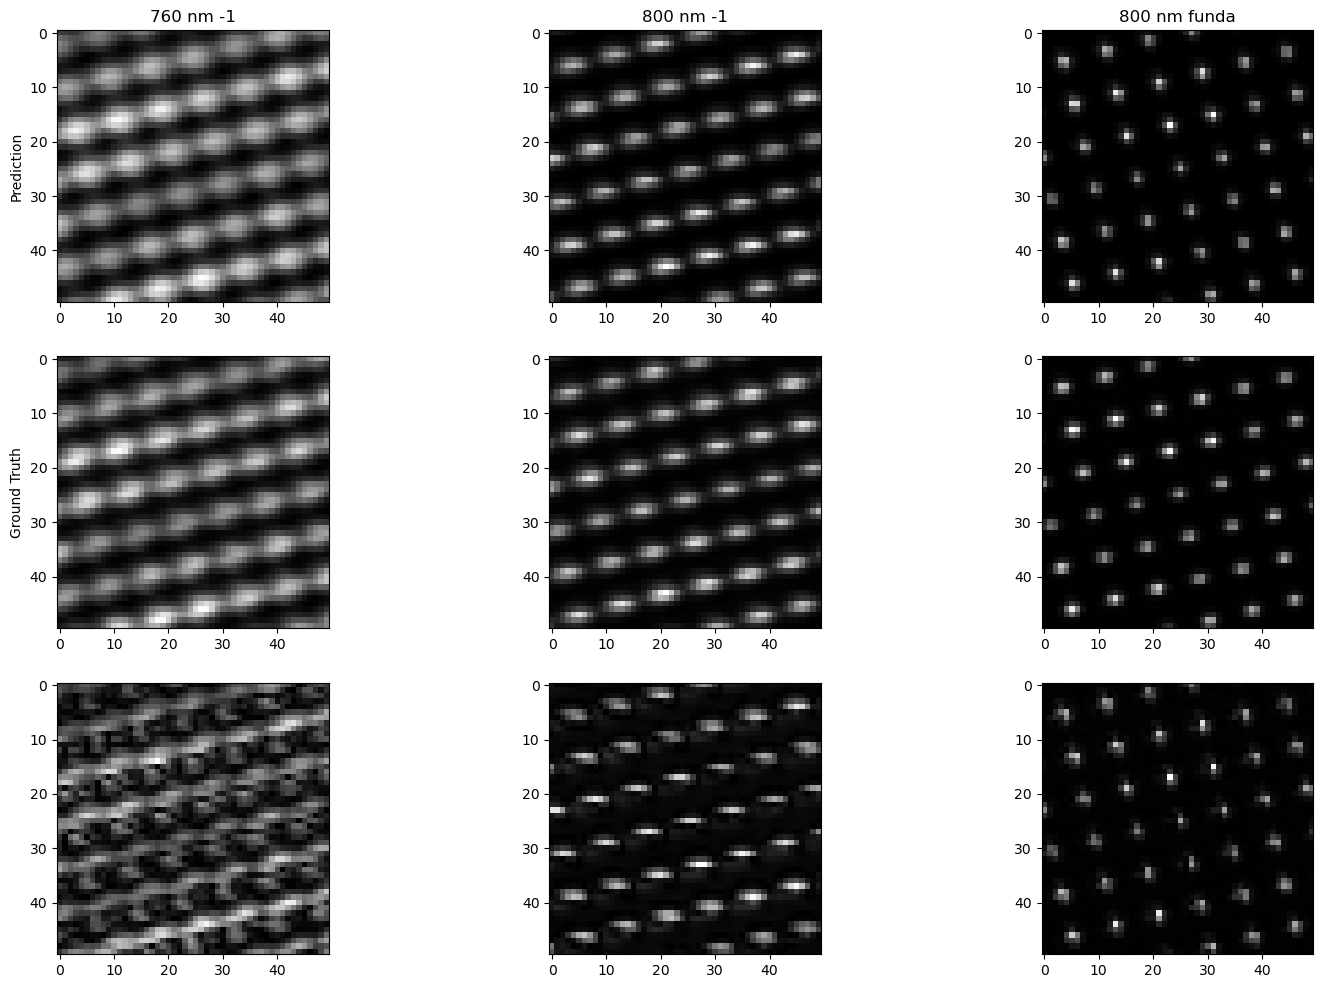

In [219]:
fig,ax = plt.subplots(3,3, figsize=(18,12))
ax[0,0].imshow(pred[0,0,200:250,200:250].numpy(), cmap='gray',); ax[0,0].set_title('760 nm -1'); ax[0,0].set_ylabel('Prediction')
ax[1,0].imshow(mask_grating_cube[0,0,200:250,200:250].numpy(), cmap='gray',); ax[1,0].set_ylabel('Ground Truth')
ax[0,1].imshow(pred[0,1,200:250,200:250].numpy(), cmap='gray',); ax[0,1].set_title('800 nm -1')
ax[1,1].imshow(mask_grating_cube[0,1,200:250,200:250].numpy(), cmap='gray',)
ax[0,2].imshow(pred[0,1,200:250,1200:1250].numpy(), cmap='gray',); ax[0,2].set_title('800 nm funda')
ax[1,2].imshow(mask_grating_cube[0,1,200:250,1200:1250].numpy(), cmap='gray',)

ax[2,0].imshow(np.abs(pred[0,0,200:250,200:250].numpy() - mask_grating_cube[0,0,200:250,200:250].numpy()), cmap='gray',)
ax[2,1].imshow(np.abs(pred[0,1,200:250,200:250].numpy() - mask_grating_cube[0,1,200:250,200:250].numpy()), cmap='gray',)
ax[2,2].imshow(np.abs(pred[0,1,200:250,1200:1250].numpy() - mask_grating_cube[0,1,200:250,1200:1250].numpy()), cmap='gray',)


In [208]:
pred.mean(), mask_grating_cube.mean()

(tensor(2.0718e-07, dtype=torch.float64),
 tensor(1.7008e-07, dtype=torch.float64))

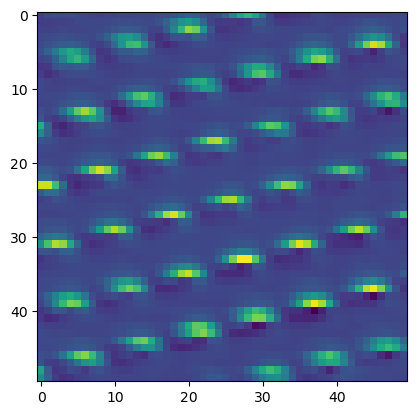

In [220]:
plt.imshow(pred[0,1,200:250,200:250].numpy() - mask_grating_cube[0,1,200:250,200:250].numpy())

Text(0.5, 1.0, 'diff')

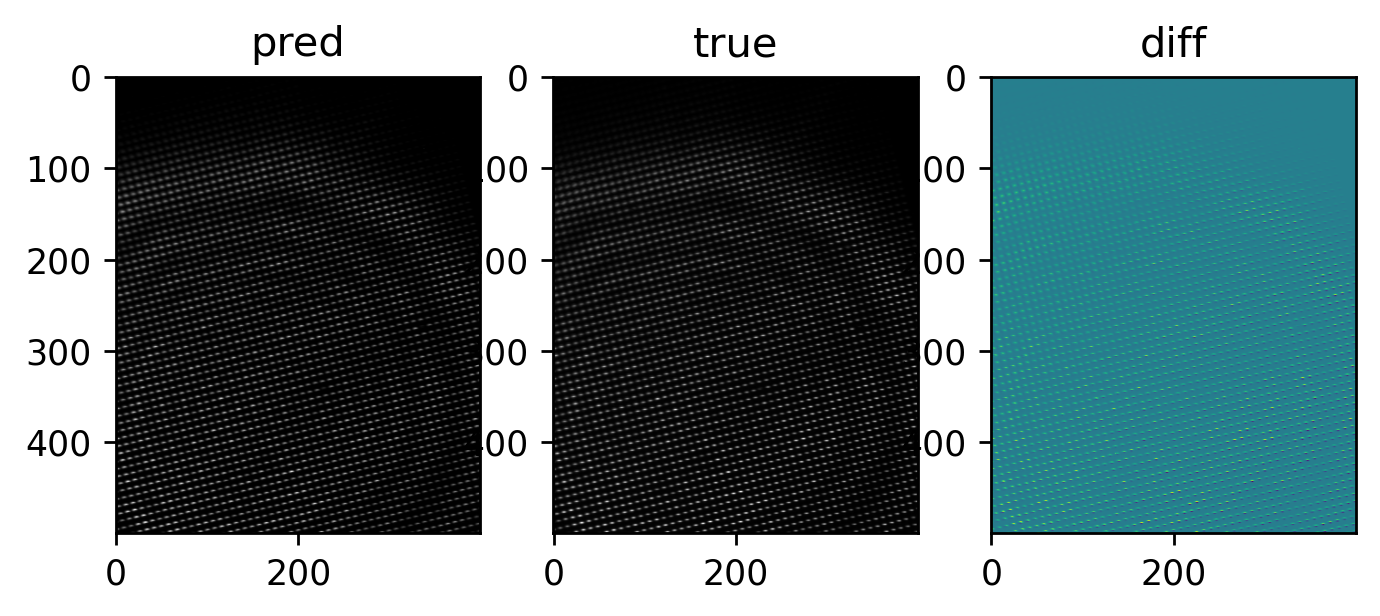

In [221]:
fig,ax = plt.subplots(1,3,dpi=250)
ax[0].imshow(pred[0,1,00:500,100:500].numpy(), cmap='gray',); ax[0].set_title('pred')
ax[1].imshow(mask_grating_cube[0,1,00:500,100:500].numpy(), cmap='gray',); ax[1].set_title('true')
ax[2].imshow(pred[0,1,00:500,100:500].numpy() - mask_grating_cube[0,1,00:500,100:500].numpy(),); ax[2].set_title('diff')

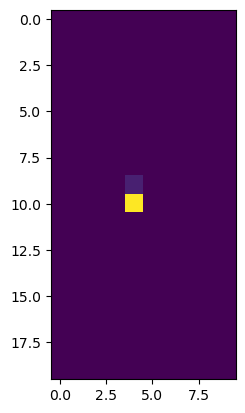

In [211]:
plt.imshow(kernel[0,2,390:410,1220:1230])

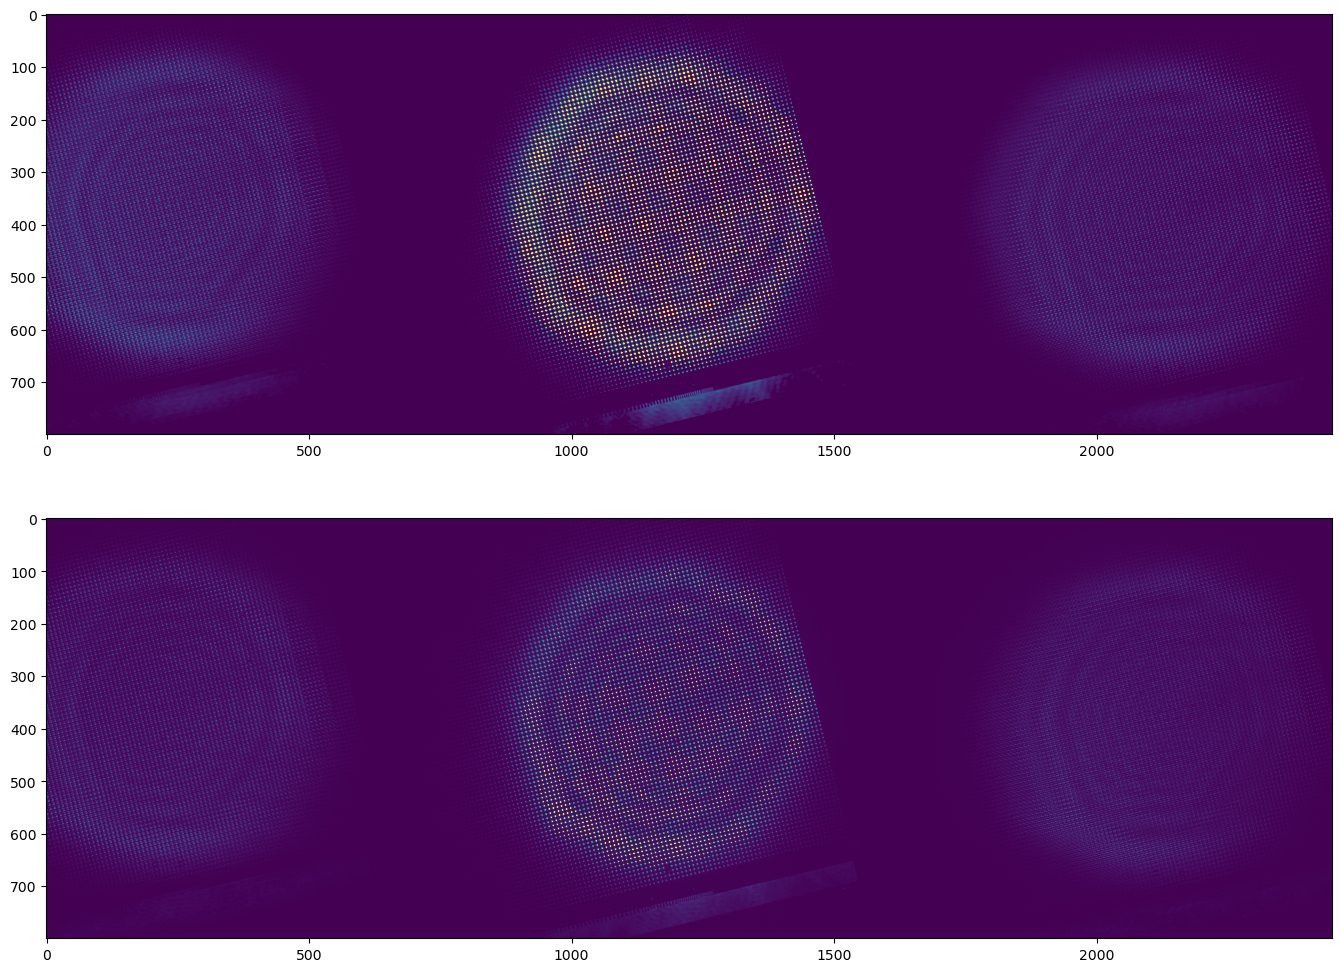

In [214]:
fig,ax = plt.subplots(2,1, figsize=(18,12))
ax[0].imshow(pred.sum(dim=(0,1)).numpy(), vmax = 0.00001)
# ax[1].imshow(mask_grating_cube[0,0].numpy(), cmap='gray',)
ax[1].imshow(torch.abs(pred - mask_grating_cube).sum(dim=(0,1)).numpy(), vmax = 0.00001)

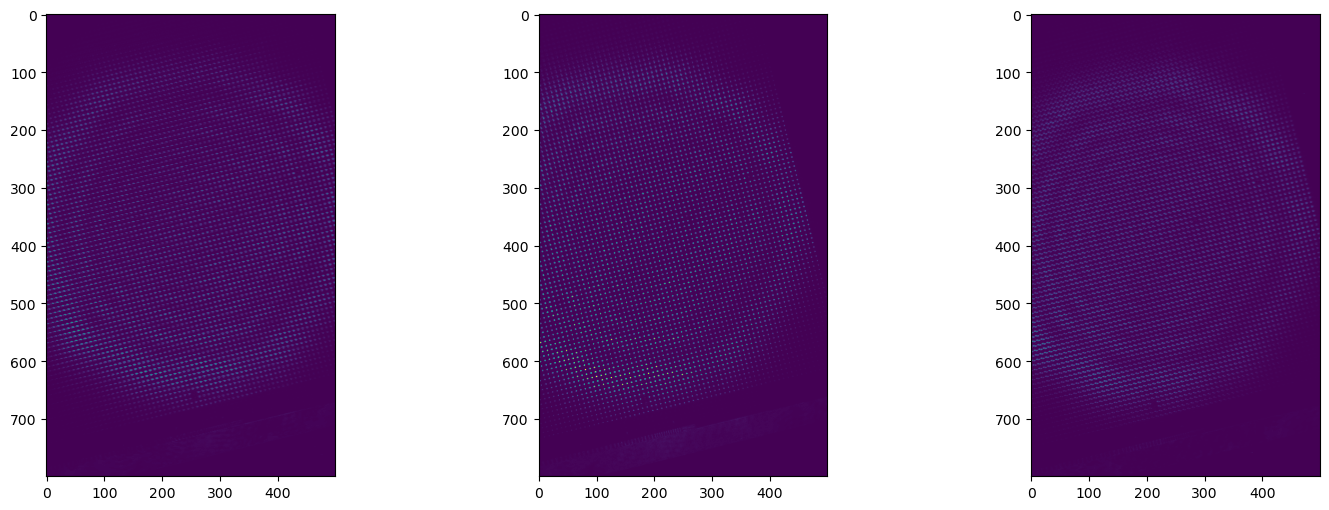

In [224]:
fig,ax = plt.subplots(1,3,figsize = (18,6))

wl = 1

ax[0].imshow(torch.abs(pred - mask_grating_cube).numpy()[0,wl,:,0:500], vmax = 0.000005)
ax[1].imshow(torch.abs(pred - mask_grating_cube).numpy()[0,wl,:,1000:1500], vmax = 0.00001)
ax[2].imshow(torch.abs(pred - mask_grating_cube).numpy()[0,wl,:,1900:2400], vmax = 0.000005)

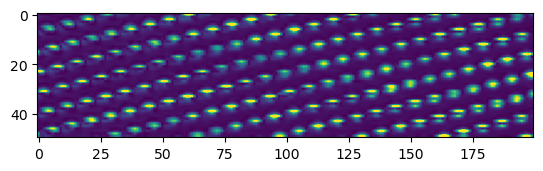

In [216]:
plt.imshow(torch.abs(pred - mask_grating_cube).numpy()[0,1,200:250,200:400], vmax = 0.000001)
